# Music Genre Classification with CNNs and Spectrograms (GTZAN) - Zhang Yanxiao 23222069

## Project Overview
In this project, I will use Convolutional Neural Networks (CNNs) to implement music genre classification.
This project implements a deep learning pipeline to classify music genres using the **GTZAN dataset**. By converting audio signals into **Mel Spectrograms**, we transform the audio analysis problem into an image classification task, leveraging the power of Convolutional Neural Networks (CNNs).

## Dataset
The **GTZAN dataset** is a benchmark dataset for music genre classification. It contains 1,000 audio tracks (30 seconds each) evenly distributed across 10 genres:
* Blues, Classical, Country, Disco, Hiphop, Jazz, Metal, Pop, Reggae, and Rock.

## Workflow
1. **Data Preparation**: Downloading and extracting the dataset.
2. **Exploratory Data Analysis (EDA)**: Visualizing audio waveforms, standard spectrograms, and 3D spectral plots to understand the data characteristics.
3. **Feature Engineering**:
    - **Segmentation**: Splitting 30s tracks into smaller overlapping windows to increase the dataset size and standardize input.
    - **Spectral Conversion**: Transforming raw audio into Mel Spectrograms (log-scale).
4. **Model Development**: Designing and training a custom 2D CNN architecture with regularization techniques (Dropout, L2).
5. **Evaluation**: Assessing performance using accuracy metrics, confusion matrices, and classification reports.

In [ ]:
!pip install librosa imageio imageio-ffmpeg kagglehub -q
# librosa is for audio processing, imageio and imageio-ffmpeg are for video processing
# Also install kagglehub to download dataset from Kaggle

In [ ]:
import os
import itertools
import warnings
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.io import wavfile
import soundfile as sf
import IPython.display as display
import plotly.graph_objects as go
import librosa
import librosa.display

from collections import OrderedDict
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

In [ ]:
import tensorflow as tf
tf.__version__

'2.19.0'

In [ ]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'gtzan-dataset-music-genre-classification' dataset.
Path to dataset files: /kaggle/input/gtzan-dataset-music-genre-classification


In [ ]:
# Check the contents of the downloaded folder
# kagglehub downloads the unzipped files directly, so no need to use ZipFile.
if os.path.exists(path):
    print("Dataset contents:", os.listdir(path))

    # Set the directory for later use (we'll need to update the path in later cells)
    # The dataset usually contains a 'Data' folder
    data_dir = os.path.join(path, 'Data')
    if os.path.exists(data_dir):
        print("Data folder found at:", data_dir)
else:
    print("Path does not exist.")

Dataset contents: ['Data']
Data folder found at: /kaggle/input/gtzan-dataset-music-genre-classification/Data


## Exploratory Data Analysis (EDA)

This section focuses on the preliminary analysis and visualization of the audio data to understand its underlying characteristics. We will perform the following steps:

1.  **Waveform Visualization**: Inspecting the raw time-domain amplitude of a sample audio track to observe signal structure.
2.  **Spectral Analysis**: Transforming the time-domain signal into a **Spectrogram** (Time-Frequency representation) using Short-Time Fourier Transform (STFT). This allows us to visualize the intensity of different frequencies over time, which is critical for the subsequent feature extraction process.

In [ ]:
# Inspect an audio file from the dataset.ep
# The dataset structure is typically: path/Data/genres_original/genre/file.wav

# Try to locate the genres_original folder
possible_roots = [
    os.path.join(path, 'Data', 'genres_original'),
    os.path.join(path, 'genres_original')
]

genres_root = None
for root in possible_roots:
    if os.path.exists(root):
        genres_root = root
        break

if genres_root is None:
    print(f"Error: Could not find 'genres_original' folder in {path}")
else:
    sample_path = os.path.join(genres_root, 'pop', 'pop.00001.wav')

    if os.path.exists(sample_path):
        print(f"Playing file: {sample_path}")
        display.display(display.Audio(sample_path))
    else:
        print(f"File not found: {sample_path}")

Playing file: /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/pop/pop.00001.wav


y: [0.7692261  0.2246399  0.69036865 ... 0.21218872 0.21685791 0.24371338] 

y shape: (661504,) 

Sample rate (Hz): 22050 

Length of audio: 30.00 seconds


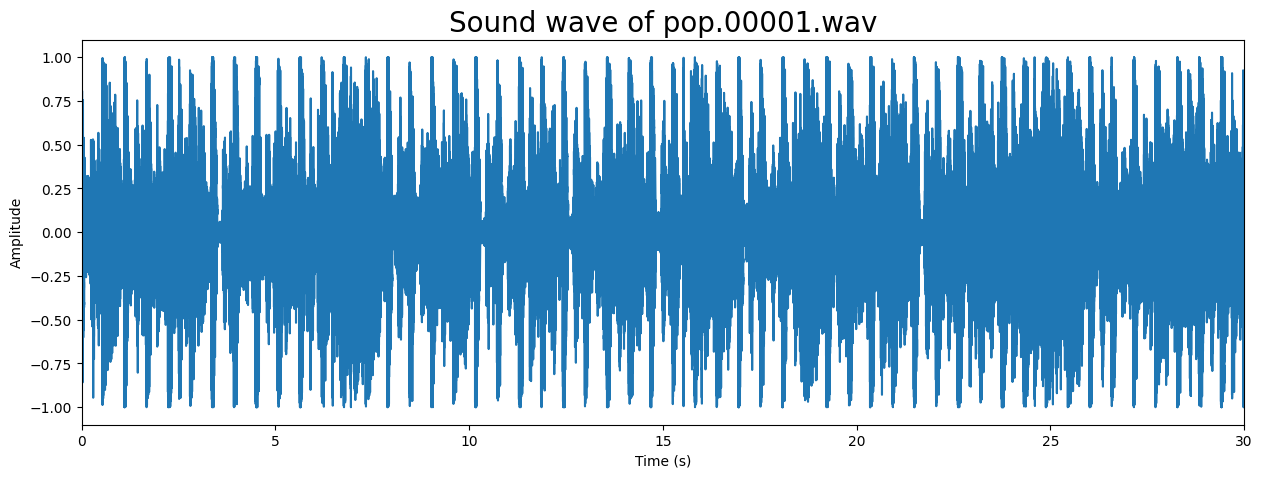

In [ ]:
# Check if sample_path is defined and valid
if 'sample_path' in locals() and os.path.exists(sample_path):
    y, sample_rate = librosa.load(sample_path)
    print('y:', y, '\n')
    print('y shape:', np.shape(y), '\n')
    print('Sample rate (Hz):', sample_rate, '\n')
    print(f'Length of audio: {np.shape(y)[0]/sample_rate:.2f} seconds')

    # Plot the sound wave.
    plt.figure(figsize=(15, 5))

    times = np.linspace(0, len(y) / sample_rate, num=len(y))
    plt.plot(times, y)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.xlim([0, len(y) / sample_rate])

    # Dynamic title based on the actual file name
    plt.title(f"Sound wave of {os.path.basename(sample_path)}", fontsize=20)
    plt.show()
else:
    print("Variable 'sample_path' is not defined or the file does not exist. Please run the previous cell.")

### Convert sound wave to spectrogram.


Shape of D object: (1025, 1293)


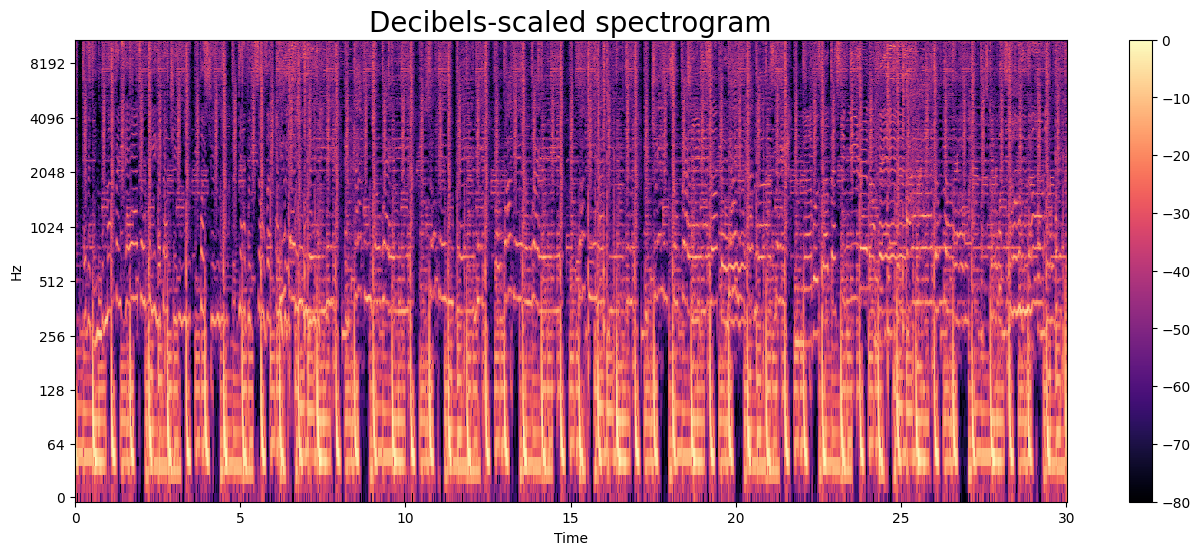

In [ ]:
# Short-time Fourier transform (STFT).
D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
print('Shape of D object:', np.shape(D))

# Convert amplitude spectrogram to Decibels-scaled spectrogram.
DB = librosa.amplitude_to_db(D, ref = np.max)

# Creating the spectogram.
plt.figure(figsize = (16, 6))
librosa.display.specshow(DB, sr=sample_rate, hop_length=512,
                         x_axis='time', y_axis='log')
plt.colorbar()
plt.title('Decibels-scaled spectrogram', fontsize=20)
plt.show()

In [ ]:
def create_3d_spectrogram(y, sr=22050, n_fft=2048, hop_length=512):
    # Calculate the STFT
    D = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))

    # Convert to dB scale
    D_db = librosa.amplitude_to_db(D, ref=np.max)

    # Create time and frequency arrays
    times = librosa.times_like(D, sr=sr, hop_length=hop_length)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

    # Create meshgrid for 3D surface
    time_grid, freq_grid = np.meshgrid(times, freqs) 

    # Create the 3D surface plot
    fig = go.Figure(data=[
        go.Surface(
            x=time_grid,
            y=freq_grid,
            z=D_db,
            colorscale='Viridis',
            colorbar=dict(title='Magnitude (dB)')
        )
    ])

    # Update layout
    fig.update_layout(
        title='3D Spectrogram',
        scene=dict(
            xaxis_title='Time (s)',
            yaxis_title='Frequency (Hz)',
            zaxis_title='Magnitude (dB)',
            camera=dict(
                eye=dict(x=1.8, y=1.8, z=1.2),
                up=dict(x=0, y=0, z=1)
            )
        ),
        width=1000,
        height=800
    )

    return fig

fig = create_3d_spectrogram(y, sr=sample_rate)
fig.show()

The Mel Spectrogram is a variation of the standard spectrogram that transforms the frequency axis from a linear scale to the Mel scale.

The Mel scale is a perceptual scale of pitches judged by listeners to be equal in distance from one another. It mimics the non-linear perception of sound by the human ear, which is more sensitive to differences in lower frequencies than in higher frequencies.

By using the Mel scale, we can extract features that are more aligned with human auditory perception, which is particularly effective for music genre classification and speech recognition tasks.

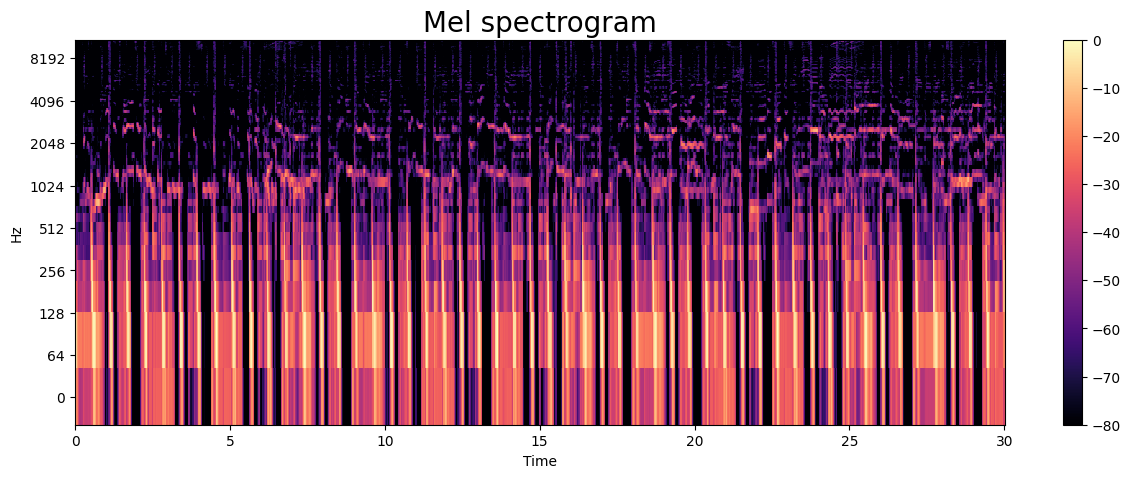

In [ ]:
# Convert sound wave to mel spectrogram.
y, sr = librosa.load(sample_path)
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(15, 5))
librosa.display.specshow(S_DB, sr=sr, hop_length=512,
                         x_axis='time', y_axis='log')
plt.colorbar()
plt.title("Mel spectrogram", fontsize=20)
plt.show()

## Process the data



### 1. `splitsongs(X, y, window, overlap)`
This function employs a sliding window technique to partition a continuous audio signal into shorter, fixed-length segments. This serves two key purposes: it standardizes input dimensions for compatibility with deep learning models that require fixed-size inputs, and it effectively augments the training dataset by generating multiple examples from a single audio source.

In [ ]:
def splitsongs(X, y, window = 0.05, overlap = 0.5):
    # 660000 x 0.05 = 33000
    temp_X = []
    temp_y = []
    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(1.-overlap))

    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        if s.shape[0] != chunk:
            continue

        temp_X.append(s)
        temp_y.append(y)

    return np.array(temp_X), np.array(temp_y)


### 2. `to_melspectrogram(songs, n_fft=1024, hop_length=256)`
Converts raw audio signals into mel-spectrogram representations using librosa. This transformation produces time-frequency representations that approximate human auditory perception, resulting in a 2D matrix format ideal for machine learning models.


In [ ]:
def to_melspectrogram(songs, n_fft=1024, hop_length=256):
    # Transformation function
    melspec = lambda x: librosa.feature.melspectrogram(
        y=x.astype(np.float32), 
        n_fft=n_fft,            
        hop_length=hop_length,  
        n_mels=128              

    )[:,:,np.newaxis]

    # map transformation of input songs to melspectrogram using log-scale
    tsongs = map(melspec, songs)

    return np.array(list(tsongs))


### 3. `load_audio_file(file_path, duration=None)`
Implements a robust audio loading utility with a prioritized fallback chain. It attempts to load using scipy.io.wavfile (optimal for .au files), then soundfile, and finally librosa as a universal fallback. The function standardizes the output by converting the audio signal to a floating-point format and returns the waveform alongside its sample rate. Comprehensive error handling ensures an informative message is returned if all loading methods fail.


In [ ]:
def load_audio_file(file_path, duration=None):
    """
    Safely load an audio file with multiple backends
    """
    # Try scipy.io.wavfile first (good for .au files)
    try:
        sr, signal = wavfile.read(file_path)
        # Normalize if needed
        if signal.dtype == np.int16:
            signal = signal.astype(np.float32) / 32768.0
        elif signal.dtype == np.int32:
            signal = signal.astype(np.float32) / 2147483648.0
        return signal, sr, None
    except Exception as e1:
        try:
            # Try soundfile next
            signal, sr = sf.read(file_path)
            return signal, sr, None
        except Exception as e2:
            try:
                # Try librosa as last resort
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    signal, sr = librosa.load(file_path, duration=duration)
                    return signal, sr, None
            except Exception as e3:
                return None, None, f"Failed to load audio with all backends"


### 4. `split_convert(X, y, song_samples)`
The main processing pipeline that:
- Takes a list of audio files and their corresponding genres
- Loads each audio file
- Handles various edge cases (mono/stereo, file length)
- Converts the audio to mel spectrograms
- Tracks and reports processing errors
- Returns processed spectrograms and one-hot encoded genre labels


In [ ]:
def split_convert(X, y, song_samples):
    arr_specs, arr_genres = [], []
    errors = [] 
    successful_files = 0

    # Convert to spectrograms and split into small windows
    print("Processing audio files...")
    for fn, genre in tqdm(zip(X, y), total=len(X)):
        # 1. Basic Check
        if not os.path.exists(fn):
            errors.append(f"File not found: {fn}")
            continue

        # 2. Load Audio
        signal, sr, error = load_audio_file(fn)
        if error is not None:
            errors.append(f"Error loading {fn}: {error}")
            continue

        # 3. Signal Processing
        if len(signal.shape) > 1:
            signal = np.mean(signal, axis=1)
        if len(signal) < song_samples:
            errors.append(f"File too short: {fn} ({len(signal)} samples)")
            continue
        signal = signal[:song_samples]

        try:
            signals, y_split = splitsongs(signal, genre)
            specs = to_melspectrogram(signals)
            arr_genres.extend(y_split)
            arr_specs.extend(specs)
            successful_files += 1

        except Exception as e:
            errors.append(f"Error processing {fn}: {str(e)}")
            continue
    return np.array(arr_specs), to_categorical(arr_genres)


### 5. `read_data(src_dir, genres, song_samples)`
The top-level function that:
- Scans directories for audio files (.wav, .mp3, .au)
- Organizes files by genre
- Splits data into training and test sets
- Processes both sets using the split_convert function
- Returns processed training and test datasets


In [ ]:
def read_data(src_dir, genres, song_samples):
    # Empty array of dicts with the processed features from all files
    arr_fn = []
    arr_genres = []

    # Get file list from the folders
    print("Scanning directories...")
    for x, _ in genres.items():
        folder = os.path.join(src_dir, x)  # Use os.path.join for path handling
        if not os.path.exists(folder):
            print(f"Warning: Genre folder not found: {folder}")
            continue

        for root, subdirs, files in os.walk(folder):
            for file in files:
                if file.endswith(('.wav', '.mp3', '.au')):  # Added .au format
                    file_name = os.path.join(folder, file)
                    arr_fn.append(file_name)
                    arr_genres.append(genres[x])

    if not arr_fn:
        raise ValueError(f"No audio files found in {src_dir}")

    print(f"Found {len(arr_fn)} audio files across {len(set(arr_genres))} genres")

    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        arr_fn, arr_genres,
        test_size=0.3,       
        random_state=42, 
        stratify=arr_genres
    )

    # Split into small segments and convert to spectrogram
    print("Processing training set...")
    X_train, y_train = split_convert(X_train, y_train, song_samples)
    print("\nProcessing test set...")
    X_test, y_test = split_convert(X_test, y_test, song_samples)

    return X_train, X_test, y_train, y_test

## Significance of the Data Processing Procedures

The implemented workflow is essential for bridging the gap between raw audio data and the requirements of deep learning models. It systematically addresses five critical aspects of music genre classification:

1.  **Input Standardization**: By segmenting variable-length audio tracks into fixed-size windows, the pipeline ensures uniform input dimensions, which is a strict requirement for CNN architectures.
2.  **Feature Engineering**: The transformation from raw waveforms to **Mel Spectrograms** extracts psychoacoustic features that align with human auditory perception, significantly enhancing the model's ability to distinguish genres.
3.  **System Robustness**: The inclusion of a multi-backend loading mechanism ensures the pipeline is fault-tolerant, capable of handling diverse audio formats and corrupt files without interruption.
4.  **Data Augmentation**: The sliding window technique with overlap not only standardizes inputs but also effectively multiplies the size of the training dataset, helping to prevent overfitting.
5.  **Model Compatibility**: The final output is structured as 3D tensors (Height, Width, Channel), making the data## Significance of the Data Processing Pipeline


In [ ]:
# Parameters
gtzan_dir = os.path.join(path, 'Data', 'genres_original')
song_samples = 660000
genres = {'metal': 0,
          'disco': 1,
          'classical': 2,
          'hiphop': 3,
          'jazz': 4,
          'country': 5,
          'pop': 6,
          'blues': 7,
          'reggae': 8,
          'rock': 9}

# Train test split
X_train, X_test, y_train, y_test = read_data(gtzan_dir, genres, song_samples)


Scanning directories...
Found 1000 audio files across 10 genres
Processing training set...
Processing audio files...


100%|██████████| 700/700 [02:50<00:00,  4.11it/s]



Processing test set...
Processing audio files...


100%|██████████| 300/300 [01:10<00:00,  4.26it/s]


In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(27261, 128, 129, 1) (11700, 128, 129, 1) (27261, 10) (11700, 10)


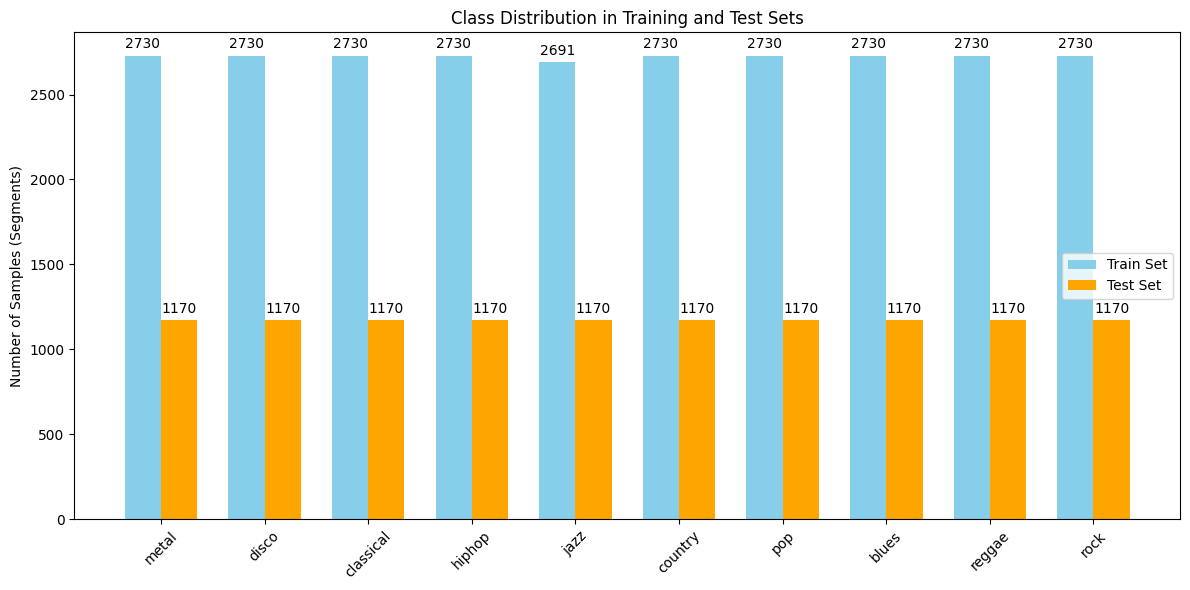

In [ ]:
# Visualization of Class Distribution
train_counts = np.sum(y_train, axis=0)
test_counts = np.sum(y_test, axis=0)

# Get genre names sorted by index
genre_names = [k for k, v in sorted(genres.items(), key=lambda item: item[1])]

x = np.arange(len(genre_names))
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, train_counts, width, label='Train Set', color='skyblue')
rects2 = ax.bar(x + width/2, test_counts, width, label='Test Set', color='orange')

# Add labels, title and custom x-axis tick labels
ax.set_ylabel('Number of Samples (Segments)')
ax.set_title('Class Distribution in Training and Test Sets')
ax.set_xticks(x)
ax.set_xticklabels(genre_names, rotation=45)
ax.legend()

# Add counts on top of bars
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

plt.tight_layout()
plt.show()

# Implementing the CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

num_classes =  len(genres)

model = Sequential()

# Input Layer
model.add(Input(shape=X_train[0].shape))

# First Convolutional Block
model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second Convolutional Block
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Third Convolutional Block
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Fourth Convolutional Block
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Fifth Convolutional Block
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten and Dense Layers
model.add(Flatten())
model.add(Dropout(0.5))

# Dense layer with L2 regularization
model.add(Dense(512, activation='relu',kernel_regularizer=l2(0.02)))
model.add(Dropout(0.25))

# Output layer
model.add(Dense(num_classes, activation='softmax',kernel_regularizer=l2(0.02)))

model.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 129, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 129, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,13

 Total params: 2,495,114 (9.52 MB)

 Trainable params: 2,495,114 (9.52 MB)

 Non-trainable params: 0 (0.00 B)

### Loss function

In [ ]:
reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.95,
    patience=3,
    verbose=1,
    mode='min',
    min_delta=0.0001,
    cooldown=2,
    min_lr=1e-5
)

In [ ]:
from tensorflow.keras.utils import Sequence
from copy import copy

class GTZANGenerator(Sequence):
    def __init__(self, X, y, batch_size=64, is_test = False):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.is_test = is_test

    def __len__(self):
        return int(np.ceil(len(self.X)/self.batch_size))

    def __getitem__(self, index):
        # Get batch indexes
        signals = self.X[index*self.batch_size:(index+1)*self.batch_size]

        # Apply data augmentation
        if not self.is_test:
            signals = self.__augment(signals)
        return signals, self.y[index*self.batch_size:(index+1)*self.batch_size]

    def __augment(self, signals, hor_flip = 0.5, random_cutout = 0.5):
        spectrograms =  []
        for s in signals:
            signal = copy(s)

            # Perform horizontal flip
            if np.random.rand() < hor_flip:
                signal = np.flip(signal, 1)

            # Perform random cutoout of some frequency/time
            if np.random.rand() < random_cutout:
                lines = np.random.randint(signal.shape[0], size=3)
                cols = np.random.randint(signal.shape[0], size=4)
                signal[lines, :, :] = -80 # dB
                signal[:, cols, :] = -80 # dB

            spectrograms.append(signal)
        return np.array(spectrograms)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.X))
        np.random.shuffle(self.indexes)
        return None


In [ ]:
# Generators
batch_size = 64
train_generator = GTZANGenerator(X_train, y_train, batch_size=batch_size)
validation_generator = GTZANGenerator(X_test, y_test, batch_size=batch_size, is_test=True)

hist = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=150,
    verbose=1,
    callbacks=[reduceLROnPlat]
)

Epoch 1/150


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



426/426 ━━━━━━━━━━━━━━━━━━━━ 32s 47ms/step - accuracy: 0.0969 - loss: 15.9451 - val_accuracy: 0.2204 - val_loss: 3.8902 - learning_rate: 0.0010
Epoch 2/150
426/426 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.1642 - loss: 3.3632 - val_accuracy: 0.1580 - val_loss: 2.5965 - learning_rate: 0.0010
Epoch 3/150
426/426 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.1771 - loss: 2.4366 - val_accuracy: 0.2247 - val_loss: 2.2134 - learning_rate: 0.0010
Epoch 4/150
426/426 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.2026 - loss: 2.2142 - val_accuracy: 0.2236 - val_loss: 2.0819 - learning_rate: 0.0010
Epoch 5/150
426/426 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.2391 - loss: 2.1134 - val_accuracy: 0.1737 - val_loss: 2.1530 - learning_rate: 0.0010
Epoch 6/150
426/426 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.2376 - loss: 2.0753 - val_accuracy: 0.2639 - val_loss: 1.9634 - learning_rate: 0.0010
Epoch 7/150
426/426 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.2512 - loss: 2.034

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

val_loss = 1.020 and val_acc = 0.719


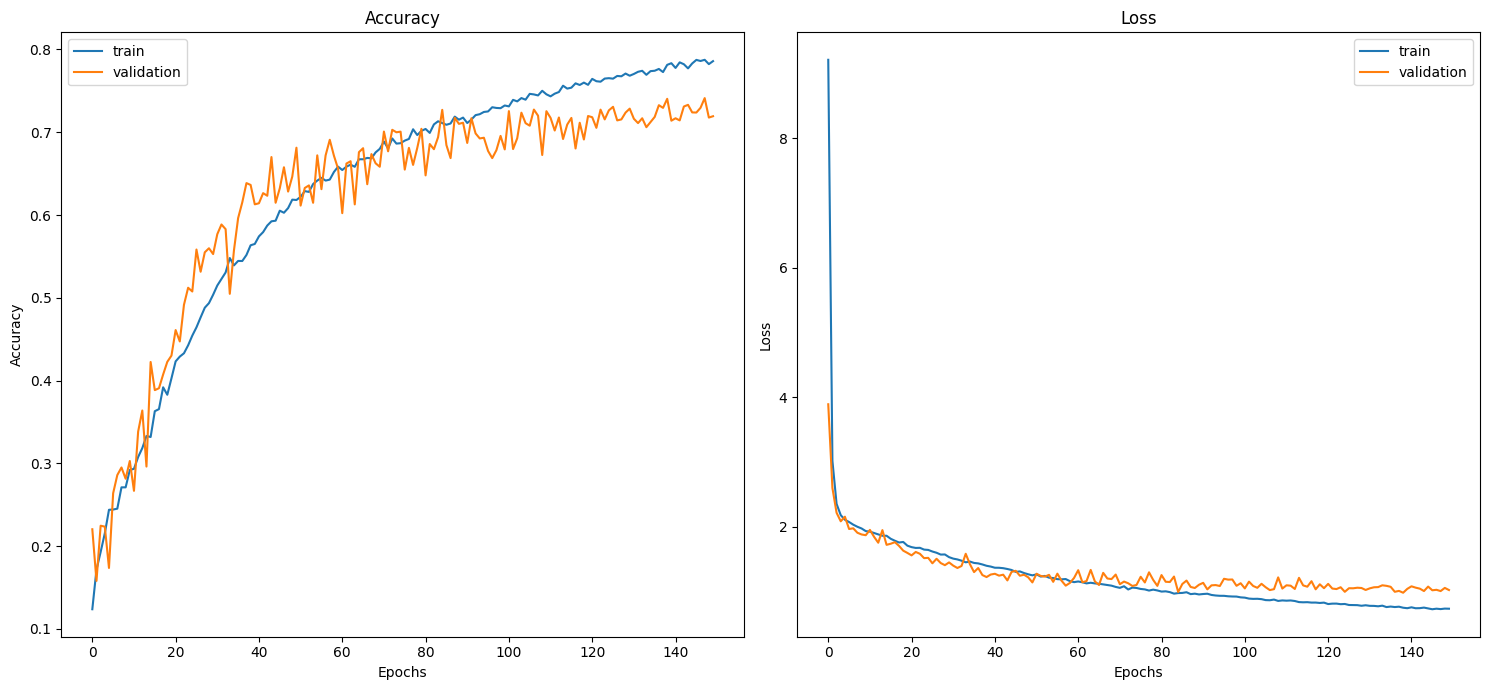

In [ ]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


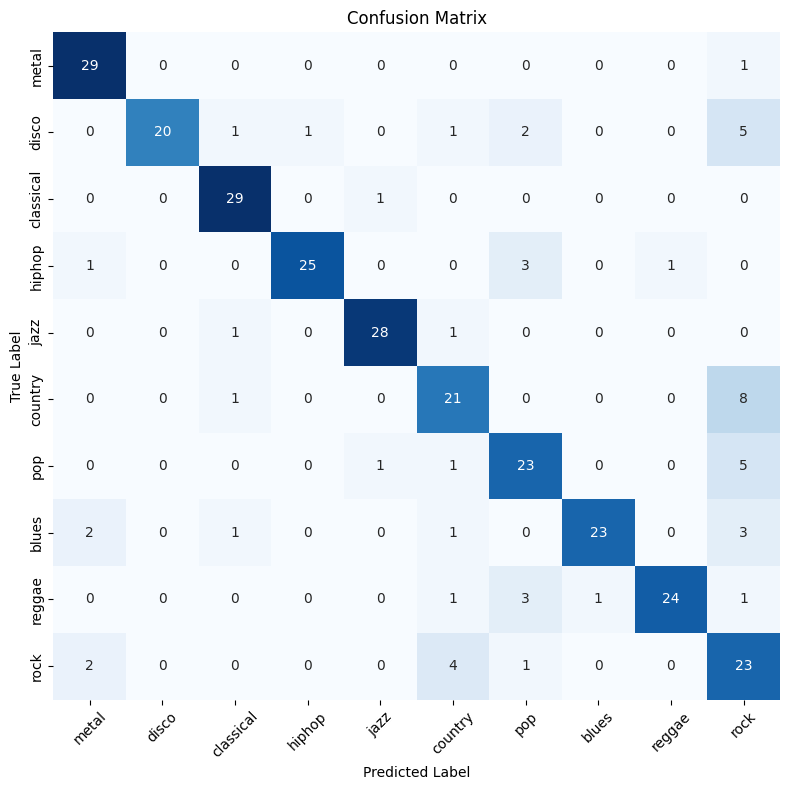


Accuracy per genre:
metal: 96.7%
disco: 66.7%
classical: 96.7%
hiphop: 83.3%
jazz: 93.3%
country: 70.0%
pop: 76.7%
blues: 76.7%
reggae: 80.0%
rock: 76.7%

Total accuracy: 81.7%


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix as sklearn_confusion_matrix # Rename sklearn function to avoid conflict

def plot_confusion_matrix(y_pred, y_test, genres, segments_per_song=39): # （Total - Window) / Stride + 1 = 39
    # 33000 * ( 1 - 0.5) = 16500
    # Get predictions per segment
    segment_predictions = np.argmax(y_pred, axis=1)
    true_labels = np.argmax(y_test, axis=1)

    # Split into songs
    n_songs = len(segment_predictions) // segments_per_song
    pred_per_song = np.array_split(segment_predictions, n_songs)
    true_per_song = np.array_split(true_labels, n_songs)
    song_predictions = [np.bincount(song).argmax() for song in pred_per_song]
    song_labels = [np.bincount(song).argmax() for song in true_per_song]

    # Calculate confusion matrix using the renamed sklearn function
    cm = sklearn_confusion_matrix(song_labels, song_predictions)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    plt.figure(figsize=(8, 8))
    genre_names = list(genres.keys())
    sns.heatmap(cm,#cm_normalized,
        annot=True,
        fmt='.0f',
        cmap='Blues',
        xticklabels=genre_names,
        yticklabels=genre_names,
        cbar=False,
    )
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Print accuracies
    print(f"\nAccuracy per genre:")
    for genre, idx in genres.items():
        mask = (np.array(song_labels) == idx)
        if np.any(mask):
            acc = np.mean(np.array(song_predictions)[mask] == idx)
            print(f"{genre}: {acc:.1%}")

    # Print total accuracy
    print(f"\nTotal accuracy: {np.mean(np.array(song_predictions) == np.array(song_labels)):.1%}")
y_pred = model.predict(X_test, batch_size=128, verbose=1)
plot_confusion_matrix(y_pred, y_test, genres)

## classification report

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
# Convert one-hot encoded labels back to class indices
y_true_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)
genre_names = [name for name, idx in sorted(genres.items(), key=lambda x: x[1])]
print(classification_report(y_true_classes, y_pred_classes, target_names=genre_names))

              precision    recall  f1-score   support

       metal       0.81      0.93      0.87      1170
       disco       0.86      0.58      0.70      1170
   classical       0.85      0.89      0.87      1170
      hiphop       0.85      0.72      0.78      1170
        jazz       0.82      0.76      0.79      1170
     country       0.60      0.57      0.59      1170
         pop       0.69      0.71      0.70      1170
       blues       0.75      0.65      0.70      1170
      reggae       0.80      0.76      0.78      1170
        rock       0.40      0.61      0.48      1170

    accuracy                           0.72     11700
   macro avg       0.74      0.72      0.72     11700
weighted avg       0.74      0.72      0.72     11700



## Save the model

In [ ]:
# Save the model
model.save('song_classification_model.keras')
